<a href="https://colab.research.google.com/github/JollygreenG-10/Prediction-of-House-Prices/blob/main/Final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Iowa Housing Prices Dataset and Modelling Using Linear Regression for Price Prediction

# 1. Executive Summary

Completion of a kaggle submission for housing price predictions involved data maniuplation and cleaning, exploratory analysis, model feature selection, model training and finally, prediction. This process was supported by resources including in-class colab notebooks for multiple linear regression and subset selection, Toward Data Science articles (links in references section), and previous personal code from multiple linear regression implementations. Data manipulation included reading training and test data, setting predictors and the response variable, and handling NA values using methods including dummy variable encoding and imputation. Analysis of the transformed training data was then completed to explore relationships between predictors and log of sale price. Data plotting was completed during this step including scatterplots to determine correlation of predictors with log sale price and histograms to explain variable distributions.  Finally, using knowledge gained from exploratory data analysis, the datasets were cleaned to remove predictors deemed unneccesary due to high correlation with other covariates, ordinal variables were label encoded, and remaining categorical predictors were converted to dummy variables in both the training and final test datasets. Forward stepwise feature selection was then completed. Forward selection involves beginning with a base model containing only an intercept parameter and gradually adding predictors to the model that minimize a key evaluation statistic. This process was performed in two ways. First, forward feature selection was performed using cross validation on a held out test set of the data.  The cross validation process used residual sum of squares (calculation of overall error in the model) to determine the ideal number of predictors to keep in the model before the full dataset was used to train a final model containing 104 predictors.  The second method that was tested for feature selection was the use of p-values to evaluate predictor significance in the model at each step.  This process resulted in a final model containing 55 predictors. The final model provided by cross validation achieved an R^2 0.905 while the p-value method achieved an R^2 of 0.898. The best Kaggle score achieved from these models was the cross validation model at 0.16247 while the p-value model achieved a score of 0.16387. From all the tested models, the lowest score achieved overall was obtained using a model with no cleaning of correlated or skewed variables and dummy variables substituted for all categorical predictors.  The score achieved by this model was 0.15126. This outcome is a possible indicator that linear regression is a poor approach for this problem or that my method has an error in the cleaning process
Submission score for p-value method:
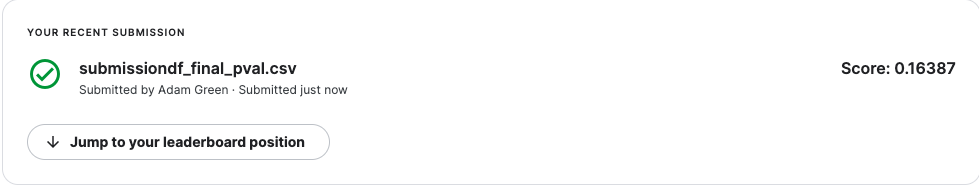
Submission score for cross validation:
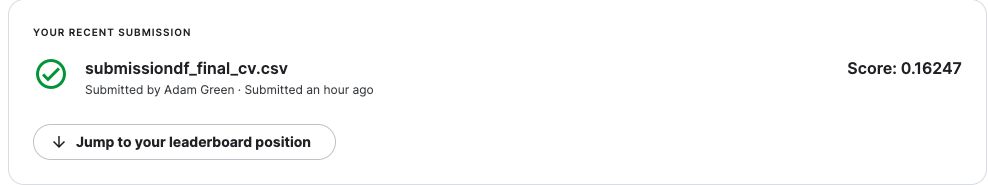
Submission score for model with no proper cleaning:
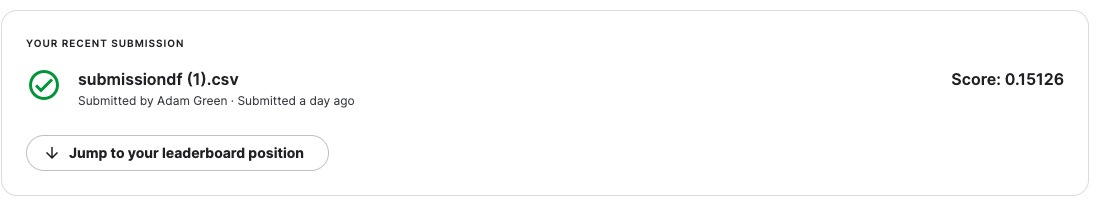


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab import files
import seaborn as sns
uploaded = files.upload() 

Saving test.csv to test.csv
Saving train.csv to train.csv


# 2. Read Data and Make Initial Formatting Changes

In [2]:
#Read data and convert response column to log()
train3 = pd.read_csv('train.csv')
test3 = pd.read_csv('test.csv')

test_noId = test3.drop(['Id'], axis = 1)
train3['logSales'] = np.log(train3['SalePrice'])
train3 = train3.drop(['Id', 'SalePrice'], axis = 1)

#identify training and test columns in full dataset 
features = train3
features['train_code'] = 1
test_noId['train_code'] = 0

dfs = [features, test_noId]
full_set = pd.concat(dfs)
print("the number of columns in the dataset is: ", len(full_set.columns))

the number of columns in the dataset is:  81


# 3. Detailed Report
## 3.1 Data cleaning and Exploratory Data Analysis

To begin the cleaning/EDA process, the dataset was explored to determine datatypes for predictors as well as predictor distributions (seen below the following code block). Next, predictors with high proportions of NA values (>60%) were removed from the dataset as well as predictors that were derived from or strongly correlated with other variables. Additional recognition of unneccessary predictors was completed using the histograms and scatterplots visualized further below.  Columns found to be uncorrelated with log sale price and columns with homogeneous values were included in the *removal* list.

In [3]:
#describe the dataset
print(full_set.info())
print(full_set.describe())

def drop_col(col):
  full_set.drop([col], inplace = True, axis = 1)

#separate continuous and categorical columns
continuous_cols = []
cat_cols = []
for i in full_set.columns:
  if full_set[i].dtype == 'int64' or full_set[i].dtype == 'float64':
    continuous_cols.append(i)
  if full_set[i].dtype == 'object':
    cat_cols.append(i)

#remove columns with > 60% NA
for j in full_set.columns:
  na_prop = (full_set[j].isna().sum())/len(full_set[j])
  if na_prop > 0.6:
    print(f'{j} was removed from the feature list')
    drop_col(j)

#selection of correlated and unneccesary columns
removal = ['BsmtFinType1',"BsmtFinSF1","BsmtFinSF2", "BsmtFinType2", 'BsmtUnfSF', 'Electrical', 
           "YearBuilt", 'OverallQual', 'OverallCond',
           '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'GarageType',
           'GarageFinish', 'GarageCars', 'SaleCondition', 'MSZoning', 'Utilities', 
           'LowQualFinSF', 'Functional', '3SsnPorch', 'PoolArea','BldgType', 'BsmtFullBath', 
           'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal', 'MoSold'] 
#drop correlated and unneccessary columns
for entry in removal:
  drop_col(entry)
print(f'{len(full_set.columns)} features remain in the dataset')



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

## 3.2 Standardization of Continuous Variables
After initial data cleaning, continuous variables were standardized to a normal distribution. This decision was largely based on histograms of predictors (available below) that indicated skewed distributions.  By standardizing these predictors, the assumptions of the linear model are more likely to be met and interpretations of individual predictors are more clear.

In [4]:
#Standardize continuous variables
from sklearn.preprocessing import StandardScaler
SC = StandardScaler()

def scaler(data):
  continuous = []
  for col in full_set.columns:
    if col != "train_code":
      if data[col].dtype == 'int64' or data[i].dtype == 'float64':
        continuous.append(col)
  for entry in continuous:
    data[entry] = SC.fit_transform(full_set[[entry]])
  return data

full_set = scaler(full_set) 
full_set.head()



,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,YrSold,SaleType,logSales,train_code
0,0.067331,65.0,-0.217879,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,TA,Y,-0.740760,0.200006,-0.359601,-0.285935,0.157646,WD,12.247694,1
1,-0.873616,80.0,-0.072044,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,TA,Y,1.614879,-0.702843,-0.359601,-0.285935,-0.602962,WD,12.109011,1
2,0.067331,68.0,0.137197,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,TA,Y,-0.740760,-0.081209,-0.359601,-0.285935,0.157646,WD,12.317167,1
3,0.302568,60.0,-0.078385,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,TA,Y,-0.740760,-0.184815,3.874967,-0.285935,-1.363569,WD,11.849398,1
4,0.067331,84.0,0.518903,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,TA,Y,0.776967,0.540424,-0.359601,-0.285935,0.157646,WD,12.429216,1


## 3.3 Encoding Ordinal Variables and Further Cleaning Data
After initial cleaning, ordinal variables were label encoded while remaining NA values in the dataset were converted to either 0 or the column mean depending on the predictor in question. Additionally, remaining categorical variables were converted to dummy variables.  This process produced a dataset of 200 columns.  Across other model building trials, attempted strategies also included removing all variables that are uncorrelated with log sale price (corr < 0.5), as well as using no encoding and only implementing dummy variables. The current method was found most effective in producing a dataset with manageable dimensionality.

In [64]:
#label encoding
ordinal_cols = ['BsmtExposure', 'BsmtQual', 'BsmtCond', 
                'ExterQual', 'ExterCond', 'FireplaceQu',
                'HeatingQC', 'GarageQual', 'GarageCond', 'PavedDrive', 'KitchenQual']


#create encoding dictionaries
encoding_libQual = {'TA': 2, 'Fa': 1, 'Gd':3, 'Ex':4 , 'Po': 0, }
encoding_libPave = {'Y':2, 'N':0, 'P':1}
encoding_libExp = {'No':0, 'Gd':3, 'Mn':1, 'Av':2}

qual = ['BsmtCond','BsmtQual', 'ExterQual', 'ExterCond', 'FireplaceQu','HeatingQC', 'GarageQual', 'GarageCond','KitchenQual']
pave = ['PavedDrive']
exp = ['BsmtExposure']

#map corresponding dictionaries
def map_codes(col, dic):
  for cols in col:
    full_set[cols] = full_set[cols].map(dic)

map_codes(qual, encoding_libQual)
map_codes(pave, encoding_libPave)
map_codes(exp, encoding_libExp)

#handle nan values in ordinal columns
for i in ordinal_cols:
  full_set[i].fillna(-1, inplace = True)




In [65]:
#Addiitonal cleaning of NA values
def counter(df, col_name):
  return (df[col_name].isna().sum())

replace_na_columns = ['MasVnrArea', 'LotFrontage', 'GarageArea']
def clean_data2(df):
  for k in replace_na_columns:
    df[k] = df[k].fillna(0)
  df['MasVnrType'] = df['MasVnrType'].fillna("None")
  meanBsmtSf = np.mean(df['TotalBsmtSF'])
  df["TotalBsmtSF"] = df["TotalBsmtSF"].fillna(meanBsmtSf)
  df.dropna(axis = 0, subset = ["TotalBsmtSF", 'Exterior1st', 'Exterior2nd', 'SaleType'])
  df = pd.get_dummies(df, dummy_na = True)
  return(df)

#produce cleaned dataset
cleaned_set = clean_data2(full_set)

#review to ensure no NA remaining
for i in cleaned_set.columns:
  na_counter = counter(cleaned_set,i)
  if na_counter > 0:
    print(f"the column {i} has {na_counter} NA values")

the column logSales has 1459 NA values


## 3.4 Plotting Data and Evaluating Relationships
After cleaning was complete, scatterplots and historgrams were produced using remaining predictors.  Scatterplots combined with correlation coefficients allowed for visual recognition of unneccesary predictors while histograms visualized predictor distributions and value counts.  Both processes were used to visually identify other predictors that could be removed from the dataset. Further discussion of removed predictors is provided below the plots. 


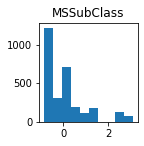

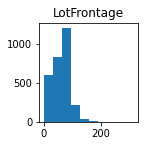

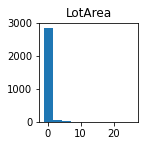

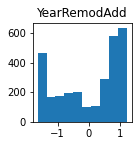

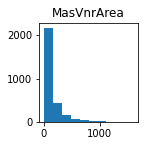

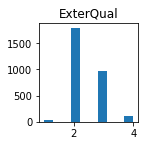

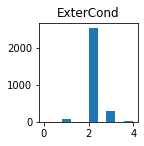

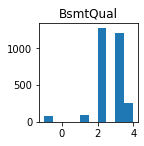

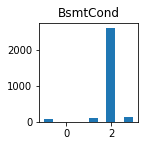

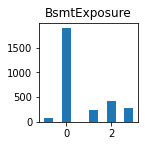

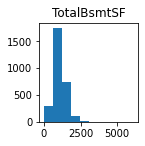

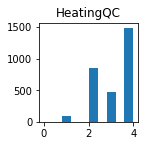

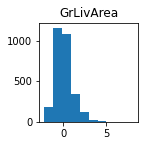

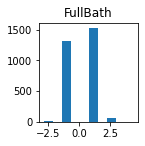

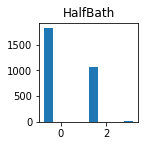

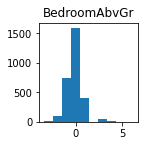

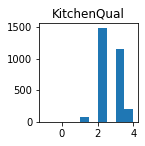

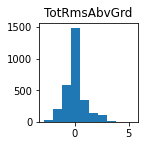

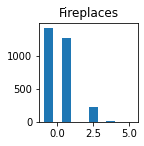

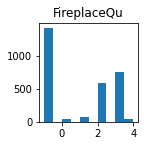

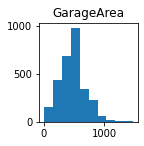

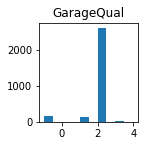

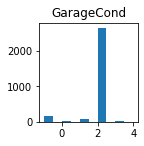

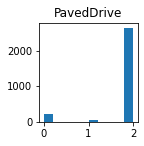

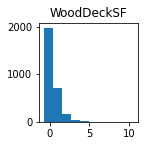

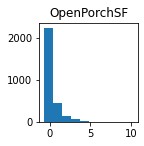

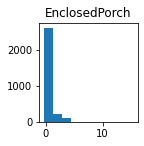

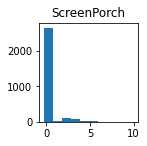

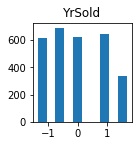

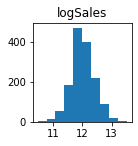

In [11]:
#Histograms to assess predictor distributions and value counts
plot_data = cleaned_set.drop(["train_code"], axis = 1)
key_columns = []
for j in plot_data.columns:
  if plot_data[j].dtype == 'int64' or plot_data[j].dtype == 'float64':
    key_columns.append(j)

for i, col in enumerate(key_columns):
  plt.subplot(2, 3, 3)
  plt.hist(plot_data[col])
  plt.title(col)
  plt.show()
    

   MSSubClass  LotFrontage   LotArea  YearRemodAdd  MasVnrArea  ExterQual  \
0    0.067331         65.0 -0.217879      0.896833       196.0          3   
1   -0.873616         80.0 -0.072044     -0.395604         0.0          2   
2    0.067331         68.0  0.137197      0.848965       162.0          3   
3    0.302568         60.0 -0.078385     -0.682812         0.0          2   
4    0.067331         84.0  0.518903      0.753229       350.0          3   

   ExterCond  BsmtQual  BsmtCond  BsmtExposure  ...  SaleType_COD  \
0          2       3.0       2.0           0.0  ...             0   
1          2       3.0       2.0           3.0  ...             0   
2          2       3.0       2.0           1.0  ...             0   
3          2       2.0       3.0           0.0  ...             0   
4          2       3.0       2.0           2.0  ...             0   

   SaleType_CWD  SaleType_Con  SaleType_ConLD  SaleType_ConLI  SaleType_ConLw  \
0             0             0            

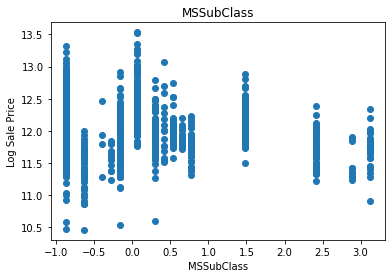

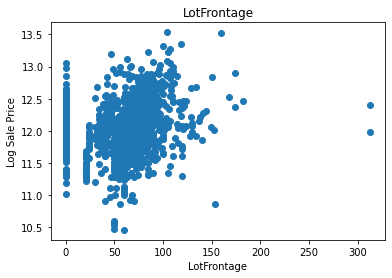

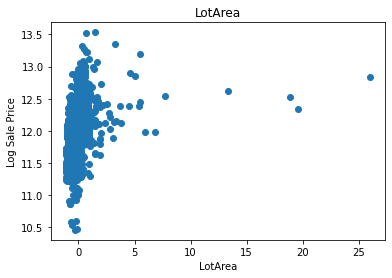

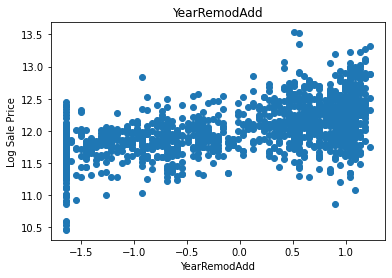

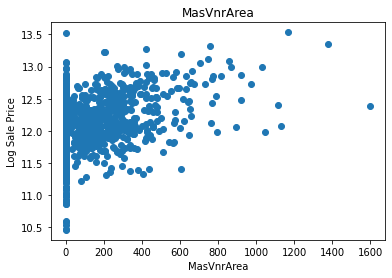

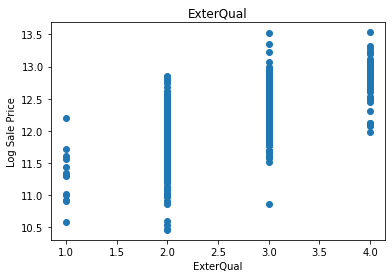

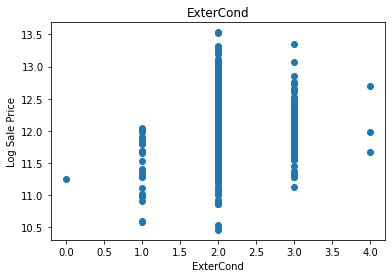

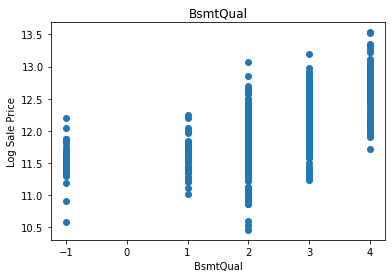

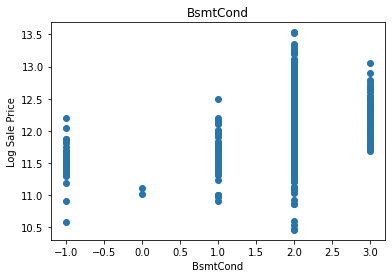

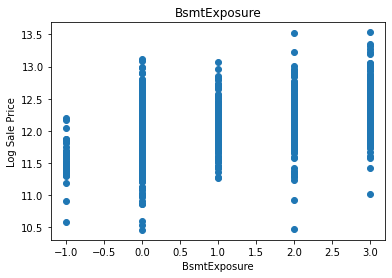

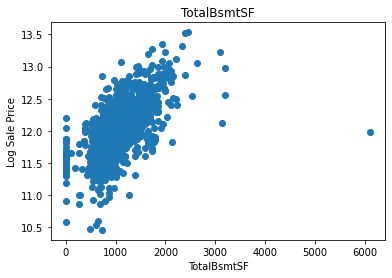

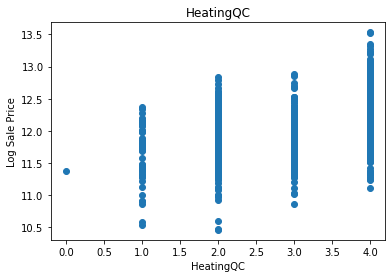

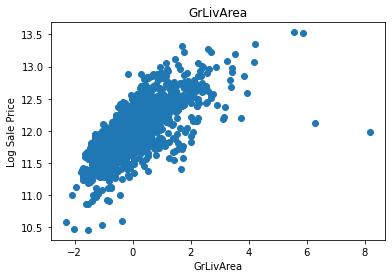

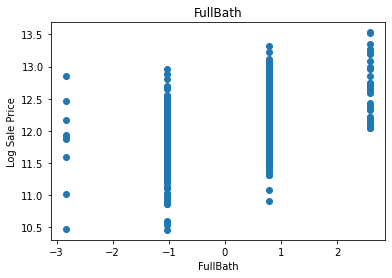

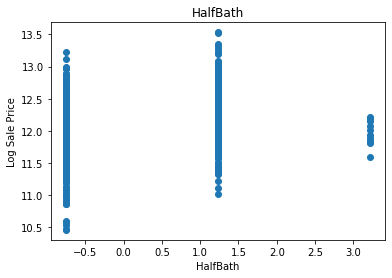

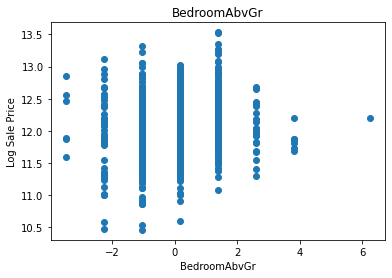

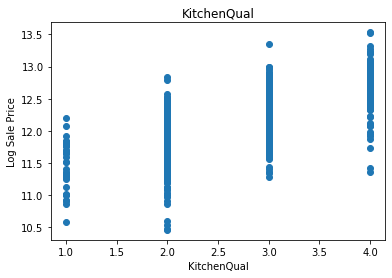

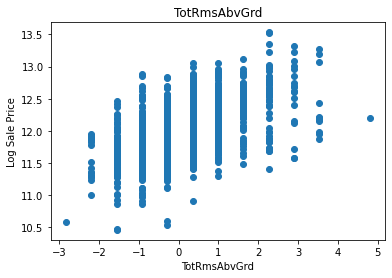

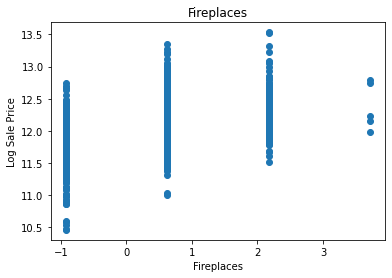

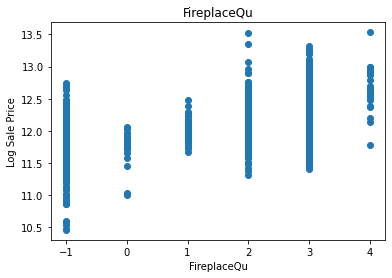

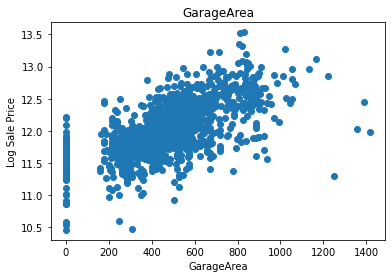

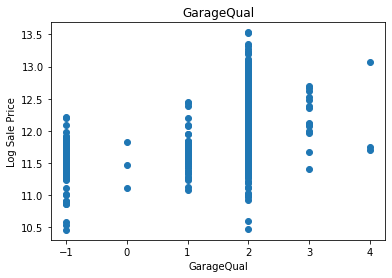

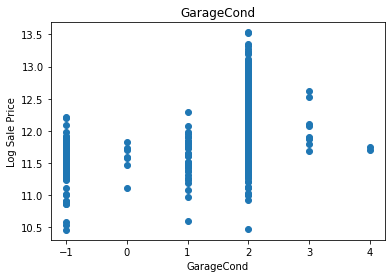

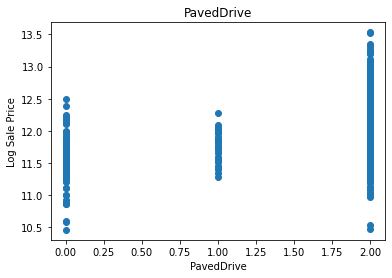

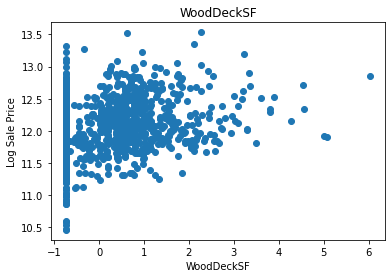

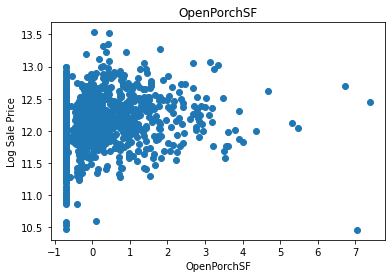

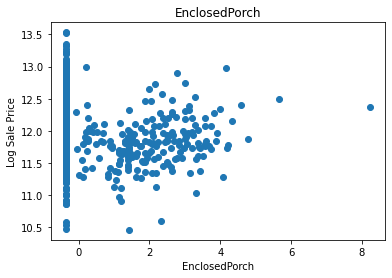

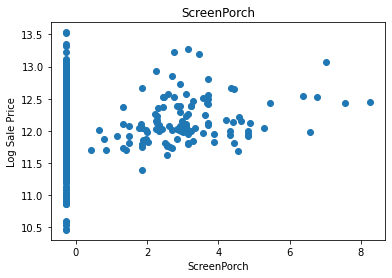

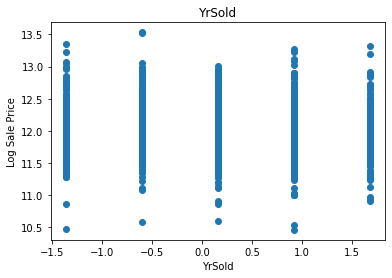

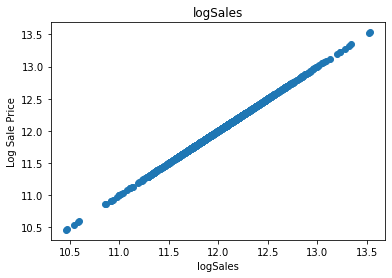

In [15]:
#Scatterplots of predictors being included in final feature selection  
trainer = cleaned_set.query('train_code == 1')

for feat in trainer.columns:
  if feat != "train_code":
    if trainer[feat].dtype == 'int64' or trainer[feat].dtype == 'float64': 
      plt.scatter(trainer[feat], trainer['logSales'])
      plt.ylabel("Log Sale Price")
      plt.xlabel(feat)
      plt.title(feat)
      plt.show()


## 3.5 Removing Correlated Columns 
The final step of data cleaning involved analyzing remaining predictors that were strongly correlated with other covariates. This process resulted in removal of three additional columns: Garage condition, total rooms above ground, and fireplace quality.  Additonally, the plots above were visually analyzed to identify predictors that were largely dependent on other covariates (ie. having overall quality as well as quality scores for each key aspect), as well as those that provided little information (columns that were mostly constant).  The result was a list of predictors to be reomved from the dataset which can be seen below (the removal of these columns took place in the *encoding variables and further data cleaning* section. 


In [66]:
#removing Correlated columns
cor_set = set()
cor_data = full_set.drop(['logSales'], axis = 1)
cor_matrix = cor_data.corr()

for x in range(len(cor_matrix.columns)):
  for z in range(x):
    if abs(cor_matrix.iloc[x, z]) > 0.8:
            colname = cor_matrix.columns[x]
            cor_set.add(colname)
print("Columns removed due to correlation: " ,cor_set)
print("Other columns removed based on plots above: ", removal)

#drop values identified as having high multicolinearity
cleaned_set = cleaned_set.drop(list(cor_set), axis =1)

Columns removed due to correlation:  {'FireplaceQu', 'GarageCond', 'TotRmsAbvGrd'}
Other columns removed based on plots above:  ['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType2', 'BsmtUnfSF', 'Electrical', 'YearBuilt', 'OverallQual', 'OverallCond', '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageCars', 'SaleCondition', 'MSZoning', 'Utilities', 'LowQualFinSF', 'Functional', '3SsnPorch', 'PoolArea', 'BldgType', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal', 'MoSold']


## 3.6 Feature Selection and model training 
Using the remaining predictors data was reclassified into training and final tests.  My strategy for feature selction involved two methods.  The first was forward feature selection using cross validation. This process involved splitting the training data into a training set and a validation set followed by stepwise addition of parameters to a model with the residual sum of squares aafter each new parameter addition being checked to determine the best parameter to add to the model. This method was performed using code presented in class to generate a reference against which to compare the second feature selection method.  The second strategy used a similar forward selection approach but decided on the best parameter to add by comparing p-values of added predictors to find the lowest at each step.  A third approach using the sci-kit learn feature selection package and the recursive feature elimination with cross-validation method was also applied, however, the forward selection methods seen below were found to be most effective, apparent from improved R^2 values. Summaries of the final trained models can be seen further below.

### 3.6.1 Forward Feature Selection Using Cross Validation

In [47]:
##Define functions to perform forward selection
#import necessary packages and select appropriate data
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
tester = cleaned_set.query("train_code == 0").drop(['train_code', 'logSales'], axis = 1)
trainer = cleaned_set.query('train_code == 1').drop(['train_code', 'logSales'], axis = 1)
labels = cleaned_set.query('train_code == 1').drop(['train_code'], axis = 1)
labels = labels['logSales']

#split training and test data
x_train, x_test, y_train, y_test = train_test_split(trainer, labels, test_size = 0.1, random_state = 20)
def fit_subset(feature_set, x_train, y_train, x_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,x_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(x_test[list(feature_set)]) - y_test) ** 2).sum()
    return {'features':feature_set, 'model':regr, 'RSS':RSS}

def forward(predictors, x_train, y_train, x_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in x_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(fit_subset(predictors+[p], x_train, y_train, x_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    return best_model





In [48]:
#Perform forward selection to identify ideal number of predictors
models_train = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(trainer.columns)+1):    
    models_train.loc[i] = forward(predictors, x_train, y_train, x_test, y_test)
    predictors = models_train.loc[i]['model'].model.exog_names



### 3.6.2 Plotting the Forward Selection with Cross-Validation Approach
The plot provided below depicts the residual sum of squares value vs. the number of predictors in the model for the best model at each step of the forward selection process.  The red dot identifies the number of predictors that resulted in the lost residual sum of squares over all.

the ideal number of predictors is:  104


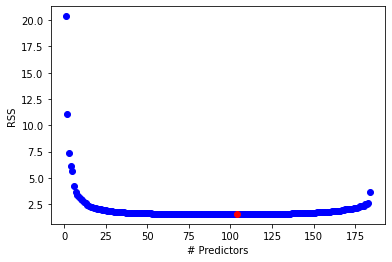

In [49]:
#Plot the residual sum of squares change curve for the forward selection process outlined above
plt.plot(models_train['RSS'],'ob')
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train['RSS'].argmin(), models_train['RSS'].min(), 'or');
feat_len = models_train.loc[models_train['RSS'].argmin()]['model'].model.exog_names
print("the ideal number of predictors is: ", len(feat_len))



In [50]:
#Perform forward selection to determine which 104 parameters to keep using the full training dataset
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(trainer.columns)+1):    
    models_full.loc[i] = forward(predictors, trainer, labels, trainer, labels)
    predictors = models_full.loc[i]['model'].model.exog_names


In [51]:
#Identifying the ideal number of parameters and which parameters to be kept in the final model 
print(sorted(models_train.loc[104, 'model'].model.exog_names))
print(sorted(models_full.loc[104, 'model'].model.exog_names))
full_feat = sorted(models_full.loc[104, 'model'].model.exog_names)
tester = tester[full_feat]
features = trainer[full_feat]
mod = sm.OLS(labels, features)
final_model = mod.fit() 
coef_dict = {"parameter": full_feat, "coefficient" : final_model.params}
print(coef_dict)

['BsmtCond', 'BsmtExposure', 'BsmtQual', 'CentralAir_N', 'Condition1_Artery', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRNe', 'Condition1_nan', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAn', 'Condition2_nan', 'ExterCond', 'ExterQual', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_nan', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'Exterior2nd_nan', 'Fireplaces', 'Foundation_BrkTil', 'Foundation_Slab', 'Foundation_nan', 'GarageArea', 'GarageQual', 'GrLivArea', 'Heating_GasW', 'Heating_OthW', 'Heating_Wall', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_SLvl', 'HouseStyle_nan', 'LandContour_Bnk', 'LandContour_Lvl', 'LandC

### 3.6.3 Forward Feature Selection Using p-values
The following code was used to complete forward feature selection using comparison of p-values to identify necessary predictors in the model. 

In [67]:
#Forward selection using p-value
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
tester2 = cleaned_set.query("train_code == 0").drop(['train_code', 'logSales'], axis = 1)
trainer = cleaned_set.query('train_code == 1').drop(['train_code', 'logSales'], axis = 1)
labels = cleaned_set.query('train_code == 1').drop(['train_code'], axis = 1)
labels = labels['logSales']

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features
#set list of features to include in the dataset 
best_features = forward_selection(trainer, labels)
print(best_features)
trainer = trainer[best_features]
tester2 = tester2[best_features]
print(len(best_features))

#fit linear model based. onlist of best features identified using forward selection method
updated_model = sm.OLS(labels, trainer).fit()
coef_dict = {"parameter": best_features, "coefficient" : updated_model.params}
print(coef_dict)

['GrLivArea', 'ExterQual', 'BsmtQual', 'GarageArea', 'CentralAir_N', 'CentralAir_Y', 'RoofMatl_ClyTile', 'Fireplaces', 'TotalBsmtSF', 'YearRemodAdd', 'Condition2_PosN', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'KitchenQual', 'Neighborhood_MeadowV', 'BsmtExposure', 'Neighborhood_Crawfor', 'LotArea', 'Neighborhood_StoneBr', 'Neighborhood_Edwards', 'Neighborhood_NridgHt', 'MSSubClass', 'Foundation_PConc', 'GarageQual', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Neighborhood_NoRidge', 'Exterior1st_BrkComm', 'MasVnrType_BrkCmn', 'ScreenPorch', 'WoodDeckSF', 'Foundation_BrkTil', 'HeatingQC', 'Condition1_Norm', 'LandSlope_Sev', 'HalfBath', 'LotConfig_CulDSac', 'Exterior2nd_CmentBd', 'Neighborhood_BrDale', 'MasVnrArea', 'SaleType_New', 'Heating_GasW', 'RoofMatl_CompShg', 'FullBath', 'HouseStyle_2.5Unf', 'Neighborhood_Veenker', 'RoofStyle_Hip', 'HouseStyle_1Story', 'Exterior2nd_AsbShng', 'Exterior2nd_BrkFace', 'Street_Pave', 'Street_Grvl', 'Condition1_RRNn', 'Condition1_RRAn', 'Condi

## 3.7 Feature Selection and modelling using RFECV
The following code block was recorded as a trial, this feature selection and training method was not used to produce a final kaggle submission score. It is included as a sample of other strategies used for feature selection. The method used in this trial, recursive feature elimination with cross validation, works by eliminating the weakest feature in the model until a specified number of features is reached or the model no longer improves with further feature removal.

In [ ]:
#Feature selection and training using Recursive feature elimination with cross validation
#this code is provide as an example of additional attempts at feature selection, it was not used in creating the final model
tester2 = cleaned_set.query("train_code == 0").drop(['train_code', 'logSales'], axis = 1)
trainer2 = cleaned_set.query('train_code == 1').drop(['train_code', 'logSales'], axis = 1)
labels2 = cleaned_set.query('train_code == 1').drop(['train_code'], axis = 1)

x_train1, x_test1, y_train1, y_test1 = train_test_split(trainer2, labels2, test_size = 0.1, random_state = 20)
print(y_train1.shape, x_train1.shape, tester2.shape)

estimator = LinearRegression()
min_features_to_select =1
feat_select = RFECV(estimator, step = 1, min_features_to_select=min_features_to_select)
feat_select = feat_select.fit(x_train1, y_train1)
index = feat_select.get_support(indices = True)

print(f"The optimal number of features is {feat_select.n_features_}")

## 3.8 Model evaluation 
The final step in the modelling process was model evaluation using summary print outs for each model. This evaluation process was minimal as the feature selection process largely performed model evaluation through comparison of p-values of model parameters and through cross-validation using a held-out test set. Evaluation of the cross validation model returned an R^2 value of 0.905 while the p-value model had an R^2 of 0.898. Both models were then used to produce a kaggle submission file using the provided test data. 

In [59]:
#retrieve summary of both linear regression models for evaluation

print(updated_model.summary())
print(final_model.summary())


                            OLS Regression Results                            
Dep. Variable:               logSales   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     233.4
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:41:41   Log-Likelihood:                 934.50
No. Observations:                1460   AIC:                            -1761.
Df Residuals:                    1406   BIC:                            -1476.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
GrLivArea                0.1109 

In [60]:
#predict housing prices for kaggle submission
tester['preds'] = np.exp(final_model.predict(tester))
submissiondf = pd.DataFrame({'Id': test3['Id'], 'SalePrice': tester['preds']})
print(submissiondf.isna().sum())
submissiondf.to_csv('submissiondf_final_pval.csv', index = False)

#Final predictions for forward selection using cross validation
tester2['preds'] = np.exp(updated_model.predict(tester2))
submissiondf2 = pd.DataFrame({'Id': test3['Id'], 'SalePrice': tester2['preds']})
print(submissiondf2.isna().sum())
submissiondf2.to_csv('submissiondf_final_cv.csv', index = False)

Id           0
SalePrice    0
dtype: int64
Id           0
SalePrice    0
dtype: int64


# 4. Interpretations
As two models were produced for the purposes of this assignment, the cross validation model was selected as the best model due to a higher R^2 value and an improved kaggle submission score. 
Interpretting this model, it was determined that the ideal number of predictors in the model was 104. A full list of these predictors as well as a list of their coeeficient values within the model is available above.  Of the parameters included in this model, 47 were actually found to be insignificant within the model, at a confidence level of 95%. Parameters found to be insignificant were largely comprised of various levels of certain dummy variables. Continuous variables included in the model such as lot area (coef 0.0283) and total basement square feet (coef 0.0001) can be compared one-to-one for their contribution to the model due to standardization of these variables earlier in the cleaning process.  This means it can be said that a unit increase in lot area leads to a larger coresponding change in log of sale price that a single unit change in total basement square feet.  For ordinal and dummy variables, similar comparisons cannot be made.  For dummy variables such as those for lot configuration interpretations can be made based on levels of the variable vs. the reference level.  For example, for a specific level of all other parameters in the model, when a house is on a corner lot, the resulting increase in log of sale price is 0.0104 compared to a house on an inside lot with the same values for all other parameters. Other dummy variables can be interpretted in the same form. Beyond individual predictors, the model overall had an R^2 value of 0.905 (ie. 9.95% of variation is unexplained). Despite having a relatively robust cleaning process, my model failed to improve upon my first trial that had little cleaning, with a total predictor count of 170.  This indicates that there could be an error in my process or incorrect use of a linear regression model. Overall, my model building process removed correlated predictors and predictors that showed no relationship with log sale price to create a model with 104 predictors found to influence housing price in Iowa. This model can now take inputs of the same datashape to predict final house price as well as allowing for inferences to be made regarding the importance of various predictors in modelling home prices.


# 5. Ethics Discussion

Through exploration and analysis of the Iowa housing dataset, a number of potential ethical issues were apparent. First, handling of NA values presented a possible source of bias.  The dataset carried a significant number of NA values across numerous columns. While the efforts to handle these values generally avoided potential bias (converting NA to the column mean, converting NA to 0 to indicate the absence of a feature where applicable), certain rows containing NA values were dropped entirely from the dataset when the source of the NA was unclear. This removal process poses a potential source of bias depending on the data points carried in the dropped rows as it could lead to an altered training process and potential misrepresentation of the variable distributions. Further, potential ethical issues could arise when interpreting the trained model in a real-world context. Due to the high dimensionality of the dataset, accurate interpretation of the model is exceedingly difficult. This means that extending the model for use in real-world applications without proper understanding could lead to inaccurate inferences and poor housing price apparaisals (ie. Certain house features could be under- or over-valued when identifying the importance of house renovations). Finally, intrisic to the dataset, ethical issues are present in the subjective rating of many housing features.  Certain predictors such as overall house quality and condition are scored based on the researcher's appraisal.  These subjective ratings could potentially reflect implicit biases held by the researchers and give way to under- or over-valuations of housing based on the ratings provided.    

# 6. References: 
Handling missing values:
https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

forward feature selection:
https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

Code for correlated feature extraction sampled from https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/

Code for forward model selection sampled and adapted from https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features
